In [2]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Copy files from Google Drive to the current Colab working directory
!cp "/content/drive/My Drive/airbus_train.zip" "airbus_train.zip"
!cp "/content/drive/My Drive/airbus_test.zip" "airbus_test.zip"
!cp "/content/drive/My Drive/train_ship_segmentations_v2.csv" "train_ship_segmentations_v2.csv"

# Create a directory named 'airbus' and unzip the train_data into it
!mkdir airbus
!unzip airbus_train.zip -d airbus

# Create a directory named 'airbus_test' and unzip the test_data into it
!mkdir airbus_test
!unzip airbus_test.zip -d airbus_test

Показано результат, скорочений до останніх рядків (5000).
  inflating: airbus/71877de80.jpg    
  inflating: airbus/db80451ad.jpg    
  inflating: airbus/a58b26457.jpg    
  inflating: airbus/e6801e5cd.jpg    
  inflating: airbus/37b3f4924.jpg    
  inflating: airbus/dc9df3f49.jpg    
  inflating: airbus/8d31a5039.jpg    
  inflating: airbus/ffda7ddfa.jpg    
  inflating: airbus/8be6b2a3d.jpg    
  inflating: airbus/4be49c47e.jpg    
  inflating: airbus/708c64c08.jpg    
  inflating: airbus/7422e204c.jpg    
  inflating: airbus/f18f80855.jpg    
  inflating: airbus/fed8be0a5.jpg    
  inflating: airbus/c66de47b6.jpg    
  inflating: airbus/9462166d9.jpg    
  inflating: airbus/c09e2c907.jpg    
  inflating: airbus/af68b0b02.jpg    
  inflating: airbus/cec7a7d10.jpg    
  inflating: airbus/4c3131456.jpg    
  inflating: airbus/c7f235a5f.jpg    
  inflating: airbus/2d6b8a130.jpg    
  inflating: airbus/36064b098.jpg    
  inflating: airbus/776392d8b.jpg    
  inflating: airbus/91248ebd4.

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('train_ship_segmentations_v2.csv')

In [65]:
# Define the directory path where image files are located
IMG_PATH = '/content/airbus'

# Create a list of file names for files with a '.jpg' extension in the specified directory
train_files_name = [f for f in os.listdir(IMG_PATH) if f.endswith('.jpg')]

# Define the original size of the images as a tuple (width, height)
ORIG_IMAGE_SIZE = (768, 768)

In [39]:
# DataFrame with train_files_name
df_img = df[df['ImageId'].isin(train_files_name)].copy()

In [13]:
print(f"Percentage of image without ships: {np.round(df_img['EncodedPixels'].isna().mean() * 100, 2)}%")

Percentage of image without ships: 49.62%


In [ ]:
# Filter images with and without ships based on the presence of EncodedPixels
mask_img_without_ships = df_img['EncodedPixels'].isna()
img_without_ships = df_img[mask_img_without_ships]
img_with_ships = df_img[~mask_img_without_ships]

# Count the number of images with ships and their occurrences
nums_img_with_ships = img_with_ships.groupby(by=['ImageId']).size().value_counts()

# Include the count of images without ships (with 0 ships)
nums_img_with_ships.loc[0] = img_without_ships.shape[0]

# Plot a bar graph using seaborn
ax = sns.barplot(x=nums_img_with_ships.index, y=nums_img_with_ships.values)

# Set title and labels for the plot
ax.set_title('Distribution numbers of ships in images')
ax.set_xlabel('Number of ships')
ax.set_ylabel('Number of images')

# Display the plot
plt.show()

In [40]:
df_img['EncodedPixels'] = df_img['EncodedPixels'].fillna('')
all_masks = df_img.groupby(by='ImageId')['EncodedPixels'].agg(lambda seq: ' '.join(seq))

In [70]:
def rle_decode(mask_rle: str, shape: tuple[int, int]) -> np.array:
    """
    :param mask_rle: Run-length encoded string representing the mask.
    :param shape: Tuple representing the shape of the target binary mask (height, width).

    :return: Binary mask as a NumPy array.
    """

    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    if isinstance(mask_rle, str):
      s = mask_rle.split()
      starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
      starts -= 1
      ends = starts + lengths
      for lo, hi in zip(starts, ends):
          img[lo:hi] = 1
    img = img.reshape(shape).T

    return np.expand_dims(img, axis=-1)

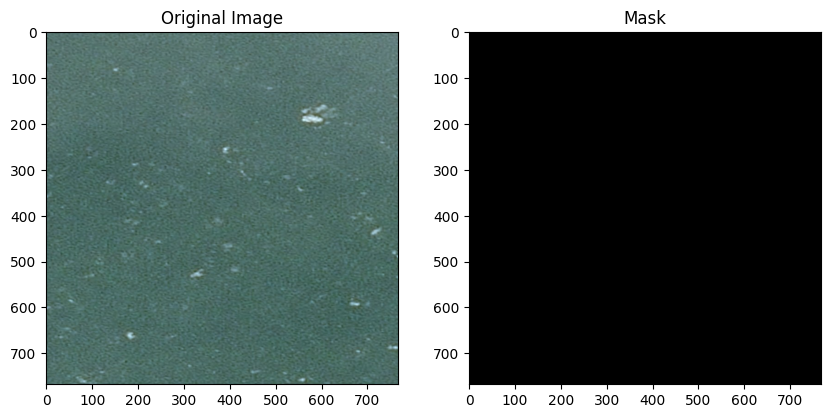

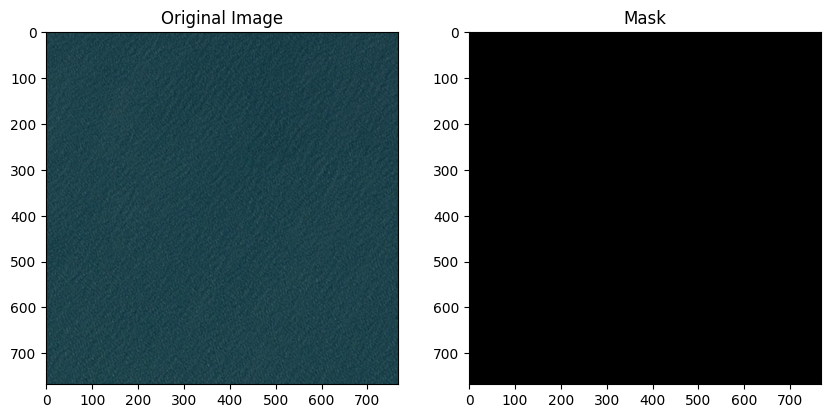

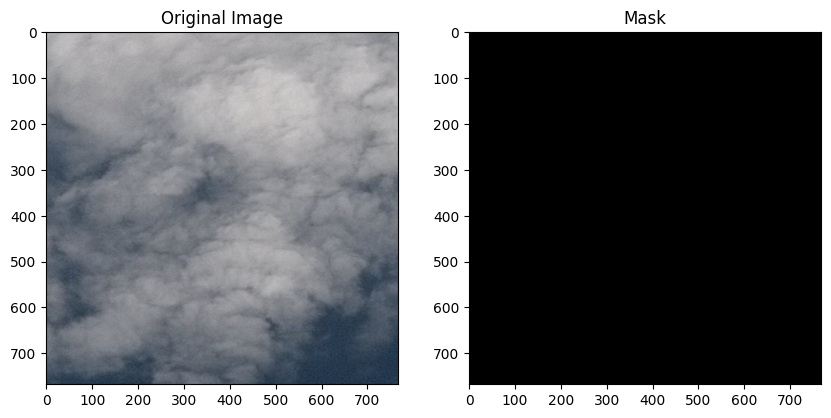

In [69]:
for i in range(3):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    img_id = img_without_ships.iloc[i, 0]
    im = plt.imread(f'{IMG_PATH}/{img_id}')

    axes[0].imshow(im)
    axes[0].set_title('Original Image')

    mask = rle_decode(all_masks.loc[img_id], ORIG_IMAGE_SIZE)

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')

    plt.show()

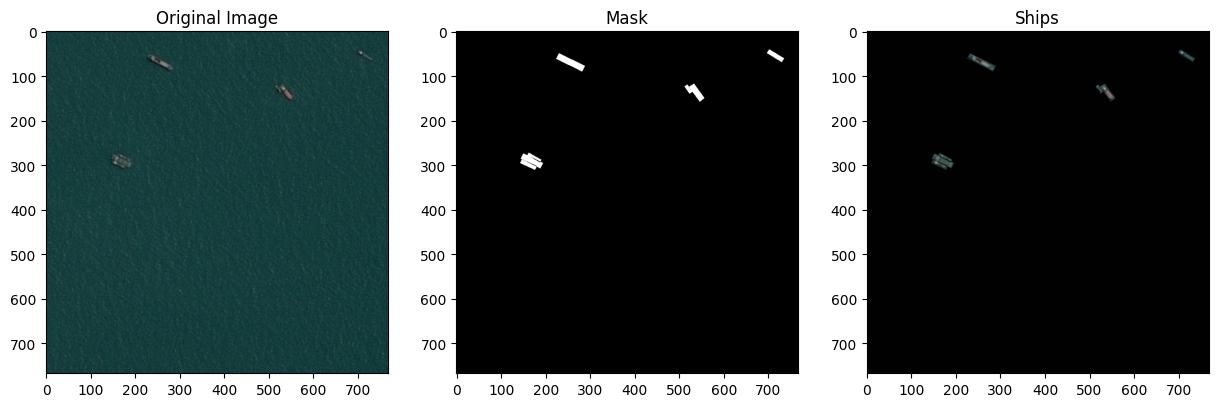

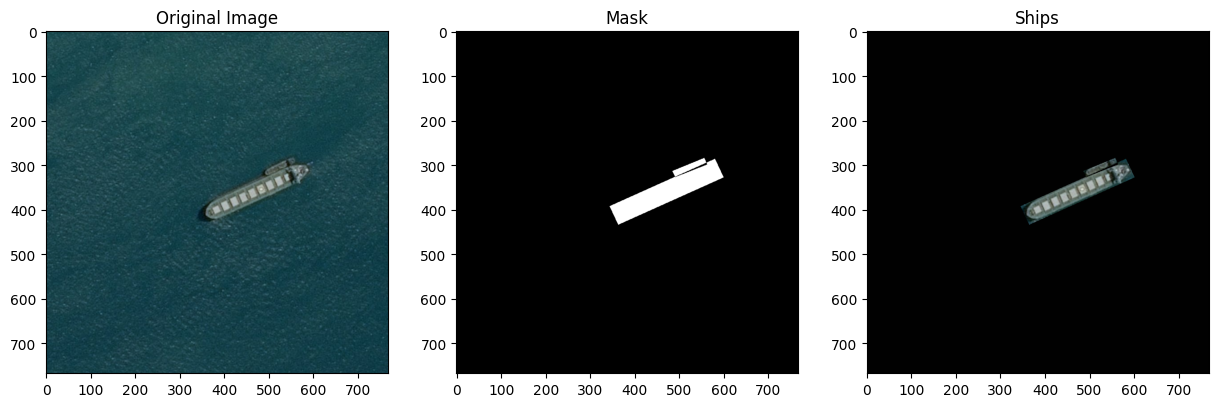

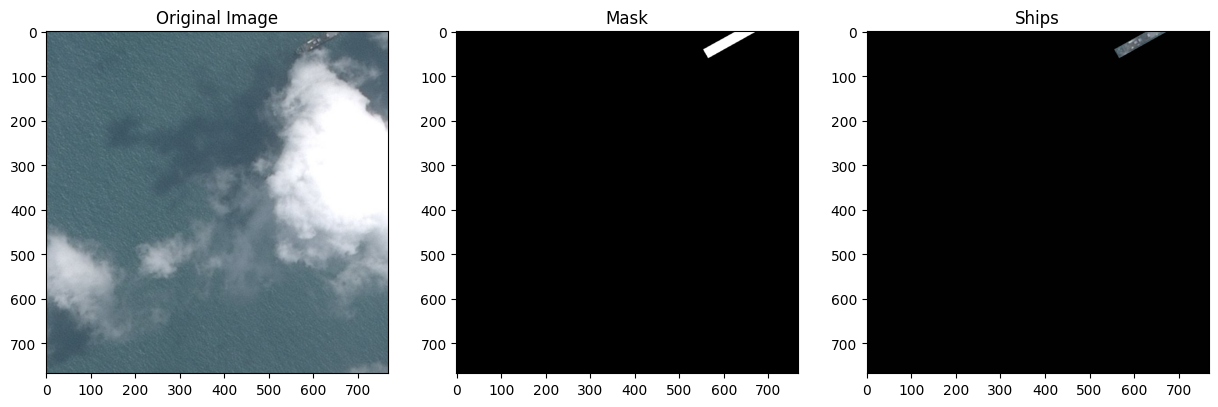

In [67]:
unique_img_id_with_ships = img_with_ships['ImageId'].unique()

for i in range(3):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    img_id = unique_img_id_with_ships[i]
    im = plt.imread(f'{IMG_PATH}/{img_id}').copy()

    axes[0].imshow(im)
    axes[0].set_title('Original Image')

    mask = rle_decode(all_masks.loc[img_id], ORIG_IMAGE_SIZE)

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')

    bool_mask = mask.squeeze().astype(bool)

    im[~bool_mask] = 1

    axes[2].imshow(im, cmap='gray')
    axes[2].set_title('Ships')
    plt.show()